# Explore here

In [1]:
!pip install seaborn
!pip install scikit-learn
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from pickle import dump

In [3]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
df = pd.read_csv(url)

In [4]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
# Asegurarse de que pandas no trunque la visualización
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)

# Imprimir los tipos de todas las columnas del dataframe 'df'
print(df.dtypes)

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [6]:
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [7]:
# Buscamos 0 en columnas donde no tiene sentido un valor de 0
# Lista de columnas
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

# Crear una máscara booleana para filas donde alguna de las columnas especificadas tiene un valor 0
mask = (df[columns_to_check] == 0).any(axis=1)

# Usar la máscara para filtrar el DataFrame
rows_with_zeros = df.loc[mask]

print(rows_with_zeros)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
5              5      116             74              0        0  25.6   
7             10      115              0              0        0  35.3   
9              8      125             96              0        0   0.0   
10             4      110             92              0        0  37.6   
11            10      168             74              0        0  38.0   
12            10      139             80              0        0  27.1   
15             7      100              0              0        0  30.0   
17             7      107             74              0        0  29.6   
21             8       99             84              0        0  35.4   
22             7      196             

## ANÁLISIS
#### Encontramos varios valores de 0 en columnas donde no tiene sentido ese valor. Vamos a seguir estudiando los datos para decidir si sustituir lso 0 por NaN y después imputar los valores faltantes, o elegir otro enfoque.

In [8]:
# Crear una copia del dataframe con valores faltantes marcados
df_missing = df.copy()
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_missing[columns_with_zeros] = df_missing[columns_with_zeros].replace(0, np.nan)

# Agregar una columna para contar los valores faltantes por fila
df_missing['missing_values'] = df_missing.isnull().sum(axis=1)

# Ver las filas con valores faltantes ordenadas por 'missing_values'
print(df_missing.sort_values(by='missing_values', ascending=False).head(20))


     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
60             2     84.0            NaN            NaN      NaN   NaN   
81             2     74.0            NaN            NaN      NaN   NaN   
522            6    114.0            NaN            NaN      NaN   NaN   
494            3     80.0            NaN            NaN      NaN   NaN   
49             7    105.0            NaN            NaN      NaN   NaN   
706           10    115.0            NaN            NaN      NaN   NaN   
426            0     94.0            NaN            NaN      NaN   NaN   
430            2     99.0            NaN            NaN      NaN  22.2   
533            6     91.0            NaN            NaN      NaN  29.8   
269            2    146.0            NaN            NaN      NaN  27.5   
261            3    141.0            NaN            NaN      NaN  30.0   
703            2    129.0            NaN            NaN      NaN  38.5   
697            0     99.0            N

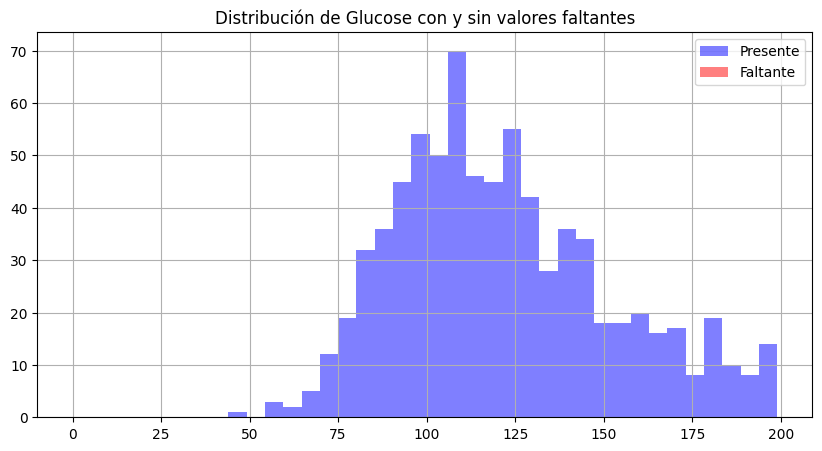

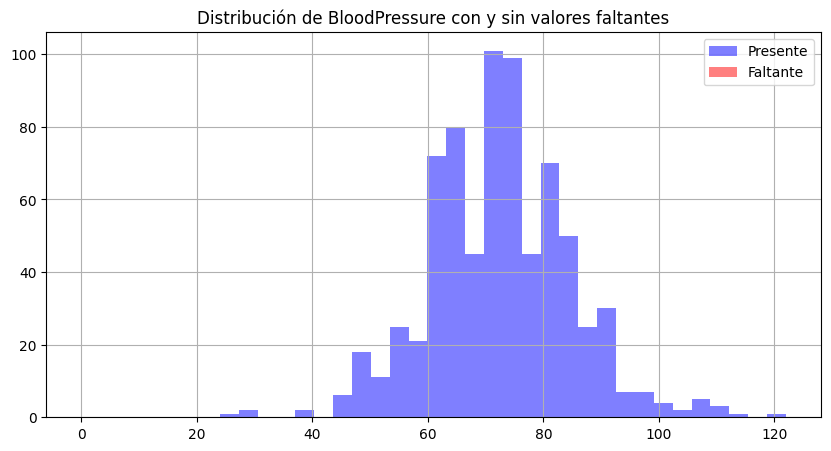

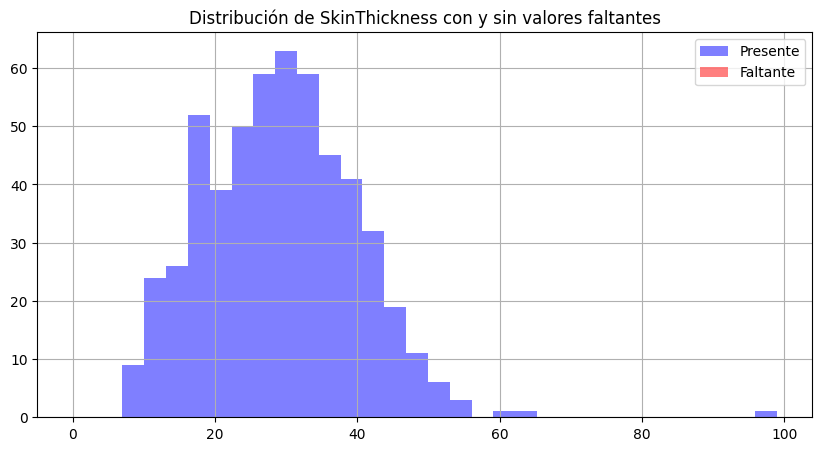

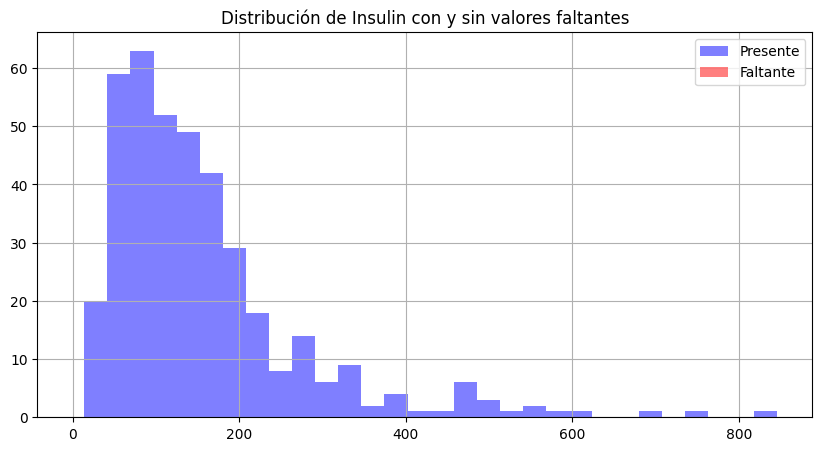

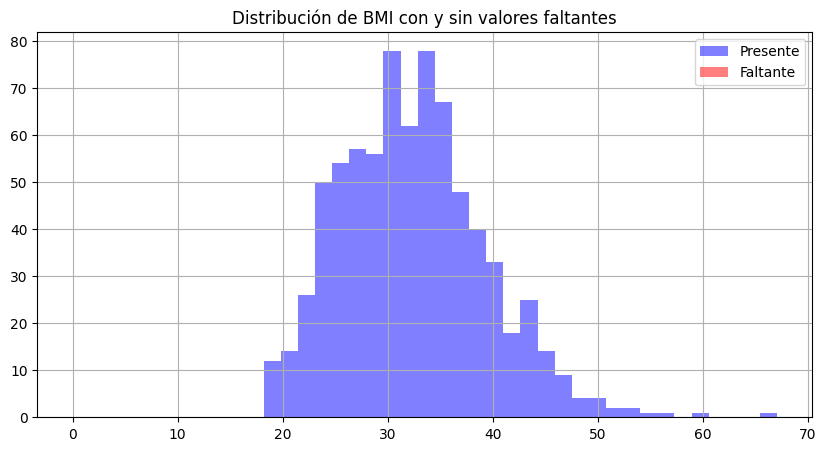

In [9]:
# Comparar distribuciones de variables clave
for column in columns_with_zeros:
    plt.figure(figsize=(10, 5))
    df_missing[df_missing[column].notnull()][column].hist(alpha=0.5, color='blue', bins=30, label='Presente')
    df_missing[df_missing[column].isnull()][column].hist(alpha=0.5, color='red', bins=30, label='Faltante')
    plt.legend()
    plt.title(f'Distribución de {column} con y sin valores faltantes')
    plt.show()

In [10]:
# Comparar la variable objetivo en filas con y sin valores faltantes
for column in columns_with_zeros:
    print(f"\nDistribución de 'Outcome' para {column} faltante vs presente:")
    print(df_missing.groupby(df_missing[column].isnull())['Outcome'].value_counts(normalize=True))



Distribución de 'Outcome' para Glucose faltante vs presente:
Glucose  Outcome
False    0          0.651376
         1          0.348624
True     0          0.600000
         1          0.400000
Name: proportion, dtype: float64

Distribución de 'Outcome' para BloodPressure faltante vs presente:
BloodPressure  Outcome
False          0          0.656207
               1          0.343793
True           0          0.542857
               1          0.457143
Name: proportion, dtype: float64

Distribución de 'Outcome' para SkinThickness faltante vs presente:
SkinThickness  Outcome
False          0          0.667283
               1          0.332717
True           0          0.612335
               1          0.387665
Name: proportion, dtype: float64

Distribución de 'Outcome' para Insulin faltante vs presente:
Insulin  Outcome
False    0          0.670051
         1          0.329949
True     0          0.631016
         1          0.368984
Name: proportion, dtype: float64

Distribución de

## CONCLUSIÓN
#### Observamos que los valores faltantes se relacionan con más casos de positivos, por lo que son influyentes en el pronóstico. Para manejar esto, optamos por una imputación KNN que dará valores más próximos a los reales con respecto a otros métodos, como usar la media o la mediana.

In [11]:
# Escalado de características para mejorar el rendimiento de KNN
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Aplicación de KNNImputer
# Puedes ajustar el número de vecinos si es necesario
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df.columns)

# Deshacer el escalado para volver al rango original de los datos
df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), columns=df.columns)

# Verificar el resultado de la imputación
print(df_imputed.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


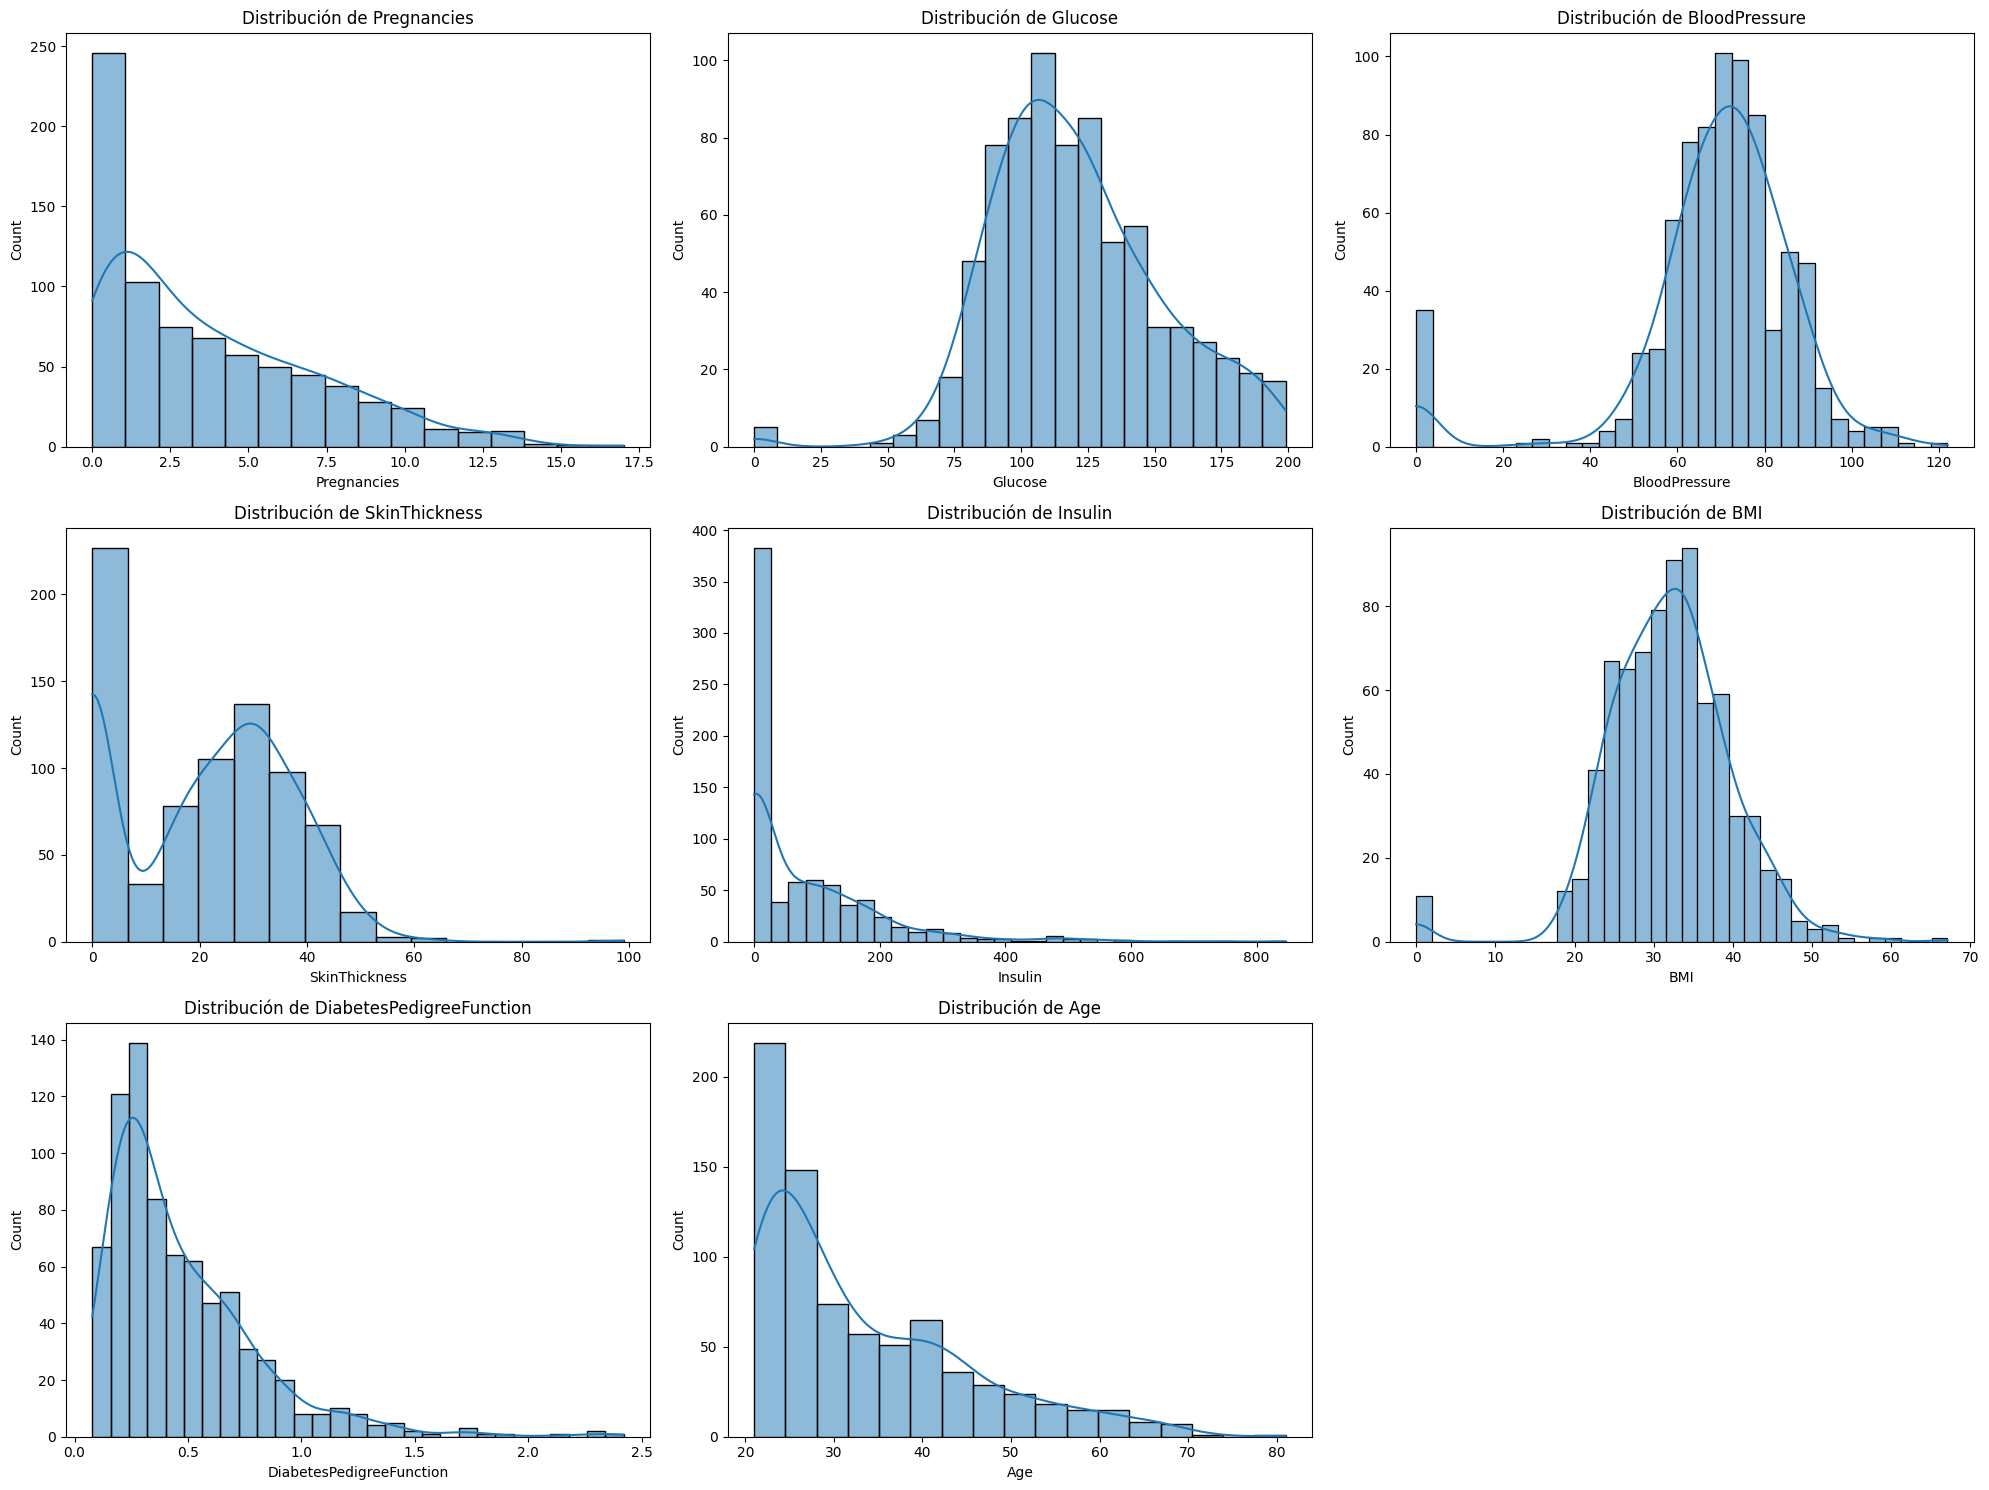

In [12]:
# Definir el tamaño del área de gráficos (ajusta según necesites)
plt.figure(figsize=(20, 15))

# Total de columnas sin contar 'Outcome'
total_columns = len(df_imputed.columns) - 1 

for i, column in enumerate(df_imputed.drop('Outcome', axis=1).columns, 1):
    plt.subplot((total_columns // 3) + 1, 3, i)
    sns.histplot(df_imputed[column], kde=True)
    plt.title(f'Distribución de {column}')

plt.tight_layout()
plt.show()

## Análisis de Histogramas
#### Pregnancies (Embarazos):
La mayoría de las observaciones tienen menos de 5 embarazos, con una distribución que se inclina hacia la izquierda, indicando que hay menos mujeres con un número alto de embarazos en el conjunto de datos.

### Glucose (Glucosa):
La variable de glucosa muestra una distribución aproximadamente normal, que es lo esperado ya que representa la concentración de glucosa en plasma.

### BloodPressure (Presión Arterial):
La distribución de la presión arterial también parece ser aproximadamente normal, aunque hay un leve sesgo hacia valores más bajos que la media, lo cual podría ser indicativo de un número significativo de medidas de presión arterial en el extremo inferior.

### SkinThickness (Grosor de la Piel):
Esta variable muestra una distribución con un pico en los valores bajos y una cola larga hacia valores más altos, sugiriendo la presencia de outliers en el extremo superior.

### Insulin (Insulina):
La insulina tiene una distribución muy sesgada hacia la derecha, con un pico muy pronunciado cerca del valor más bajo y una cola larga que se extiende hacia valores más altos, indicando la presencia de valores atípicos extremos.

### BMI (Índice de Masa Corporal):
La distribución del índice de masa corporal es aproximadamente normal, aunque parece tener un sesgo hacia la derecha, lo que indica una prevalencia de valores de BMI en el rango de sobrepeso u obesidad.

### DiabetesPedigreeFunction (Función de Pedigrí de la Diabetes):
Esta variable, que representa una función del historial de diabetes en la familia, muestra una distribución sesgada hacia la derecha, con la mayoría de los valores concentrados en el extremo inferior.

### Age (Edad):
La distribución de la edad está sesgada hacia la izquierda, lo que indica que hay una mayor cantidad de mujeres jóvenes en el conjunto de datos y menos mujeres mayores.

## Conclusión Preliminar
Las distribuciones nos proporcionan información útil sobre la forma en que las variables están distribuidas en el conjunto de datos. Para las variables con distribuciones sesgadas, especialmente Insulina y Grosor de la Piel, es importante investigar más a fondo para determinar la mejor manera de tratar estos valores antes del modelado, lo cual podría incluir transformaciones de datos o el manejo de outliers.

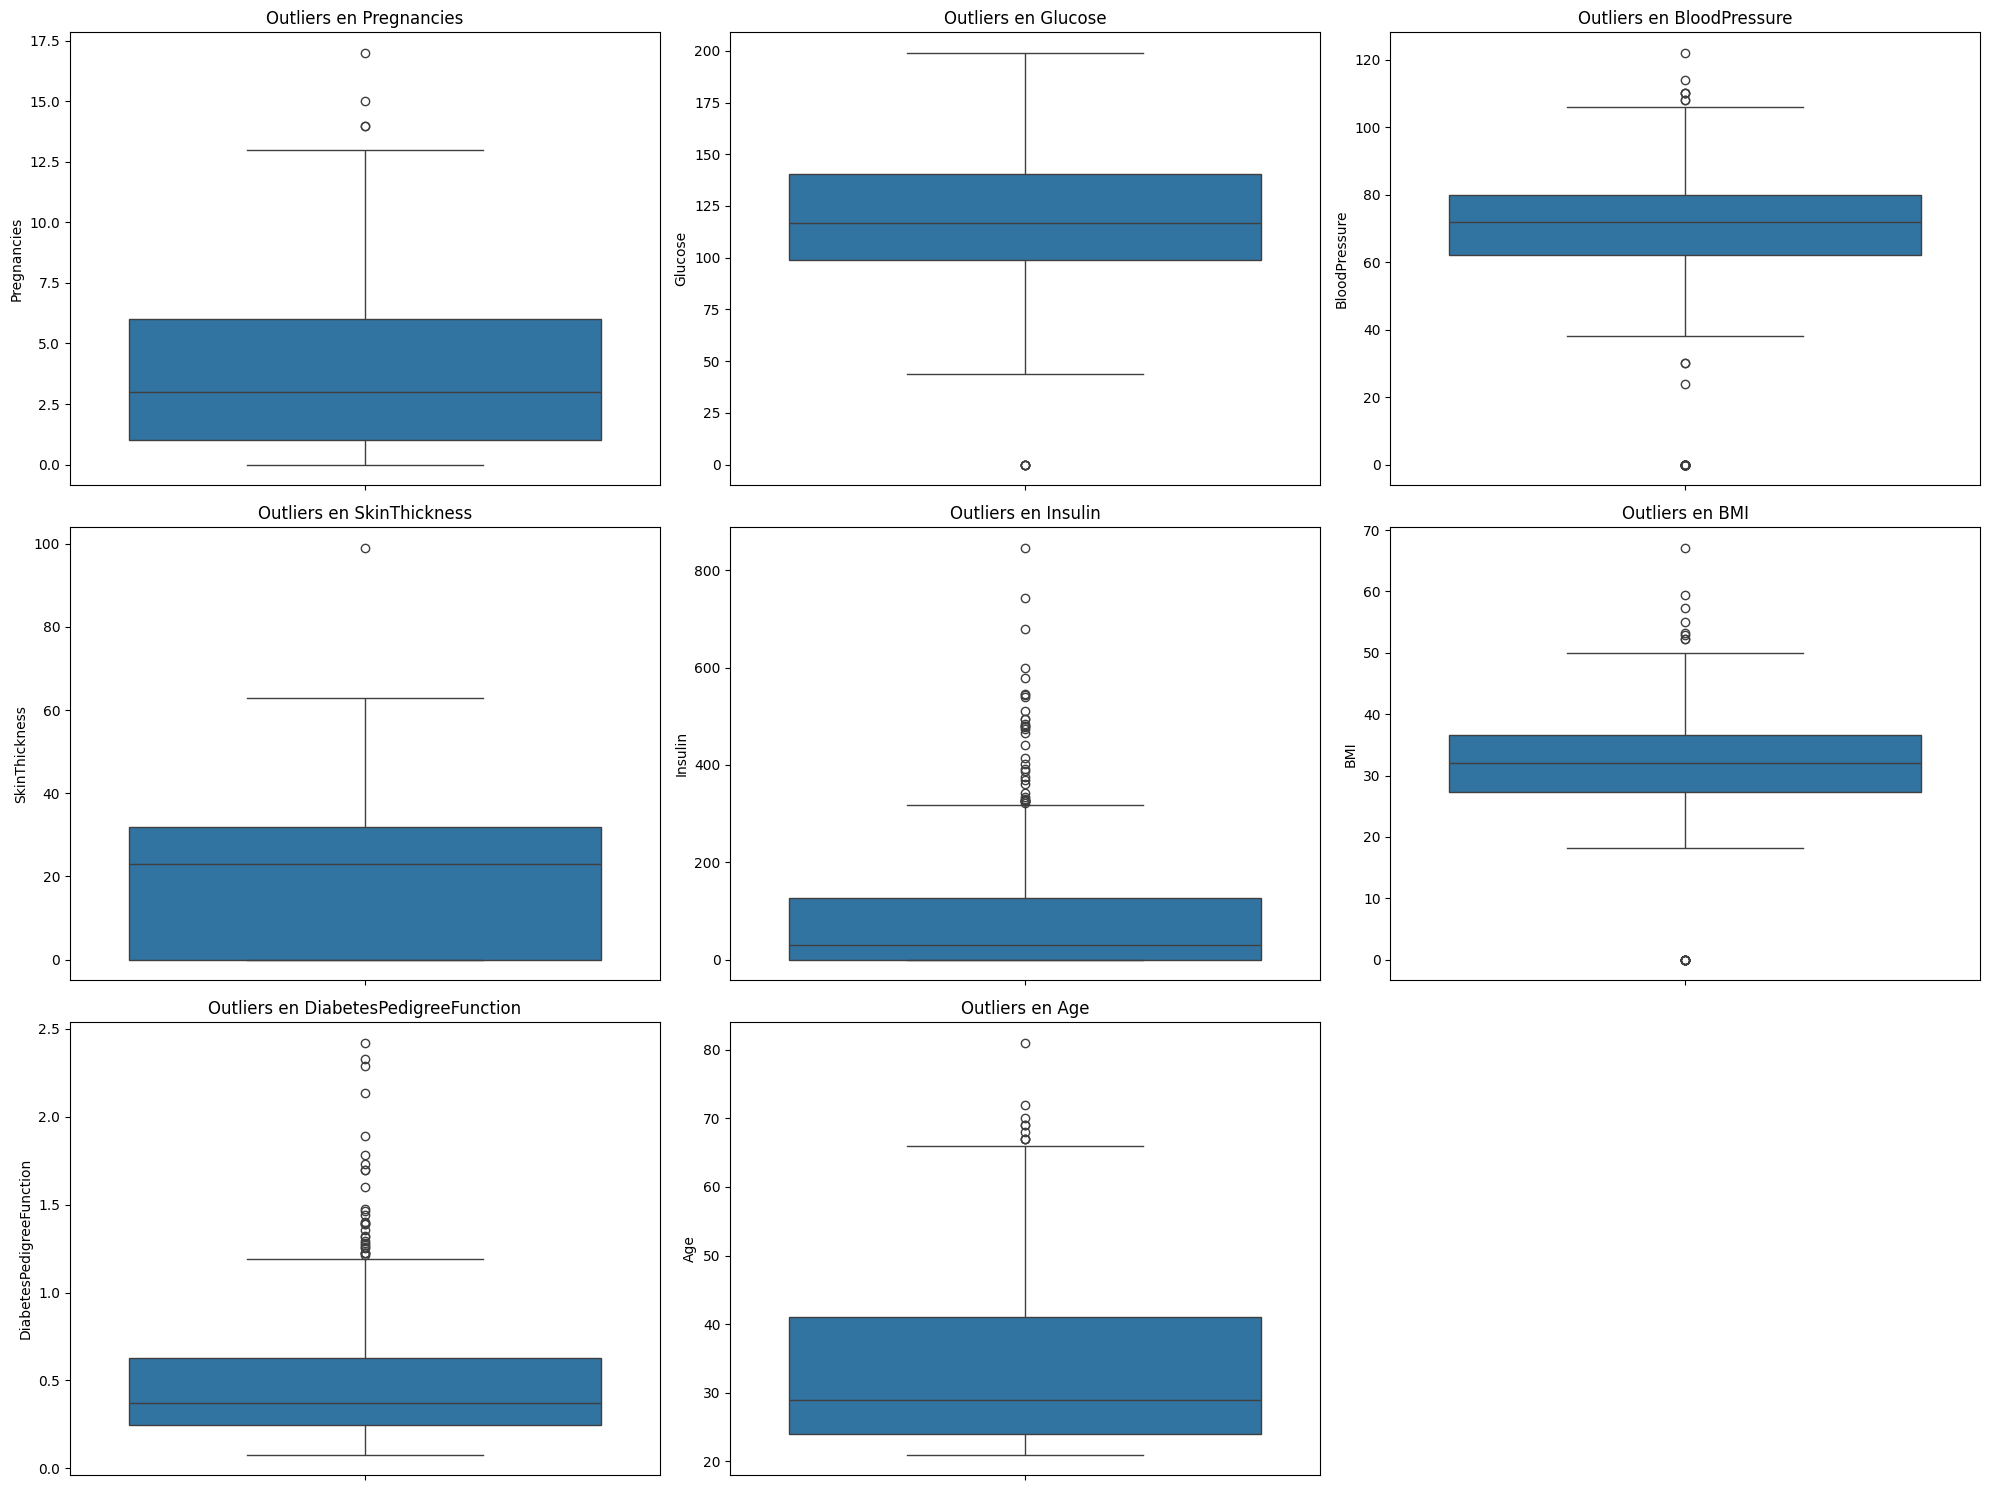

In [13]:
plt.figure(figsize=(20, 15))

for i, column in enumerate(df_imputed.drop('Outcome', axis=1).columns, 1):
    plt.subplot((total_columns // 3) + 1, 3, i)
    sns.boxplot(y=df_imputed[column])
    plt.title(f'Outliers en {column}')

plt.tight_layout()
plt.show()

##Análisis de Boxplots

### Pregnancies (Embarazos):
Hay outliers en el número de embarazos, con algunos valores extremadamente altos. Sin embargo, un número elevado de embarazos es posible y puede ser relevante para la predicción de la diabetes, por lo que estos datos podrían ser legítimos.

### Glucose (Glucosa):
No hay indicios de outliers significativos en esta variable, lo que indica que los valores de glucosa se encuentran dentro de un rango esperado para una población adulta.

### BloodPressure (Presión Arterial):
Se observan algunos outliers, principalmente en el extremo inferior. Valores muy bajos de presión arterial pueden ser preocupantes y atípicos, por lo que se deberían revisar estos casos para verificar su validez.

### SkinThickness (Grosor de la Piel):
Hay una cantidad considerable de outliers en el grosor de la piel. Esto puede deberse a errores de medición o variabilidad natural. Es importante considerar la relevancia clínica antes de decidir cómo manejar estos valores.

### Insulin (Insulina):
La insulina muestra muchos outliers, principalmente en valores altos. Este patrón es consistente con la distribución sesgada observada en el histograma y sugiere que puede ser necesario revisar estos datos o aplicar una transformación para manejar la variabilidad extrema.

### BMI (Índice de Masa Corporal):
Existen outliers en el BMI, tanto en el extremo inferior como en el superior. El sobrepeso y la obesidad son factores de riesgo para la diabetes, por lo que estos valores pueden ser clínicamente relevantes, aunque es inusual ver valores de BMI extremadamente bajos en adultos.

### DiabetesPedigreeFunction (Función de Pedigrí de la Diabetes):
Esta variable también presenta outliers. Dado que es una medida de la predisposición genética a la diabetes, puede haber variabilidad natural significativa.

### Age (Edad):
Se observan outliers en la edad, con algunos individuos significativamente mayores que la mayoría de la población del conjunto de datos. Estos casos podrían ser correctos, ya que no es inusual que la poblidad de estudio incluya personas mayores.

## Conclusión Preliminar sobre Outliers
Los outliers detectados en estas variables podrían ser tanto puntos de datos válidos como errores o variaciones extremas. Es importante verificar la calidad de los datos antes de decidir si deben ser eliminados o tratados.

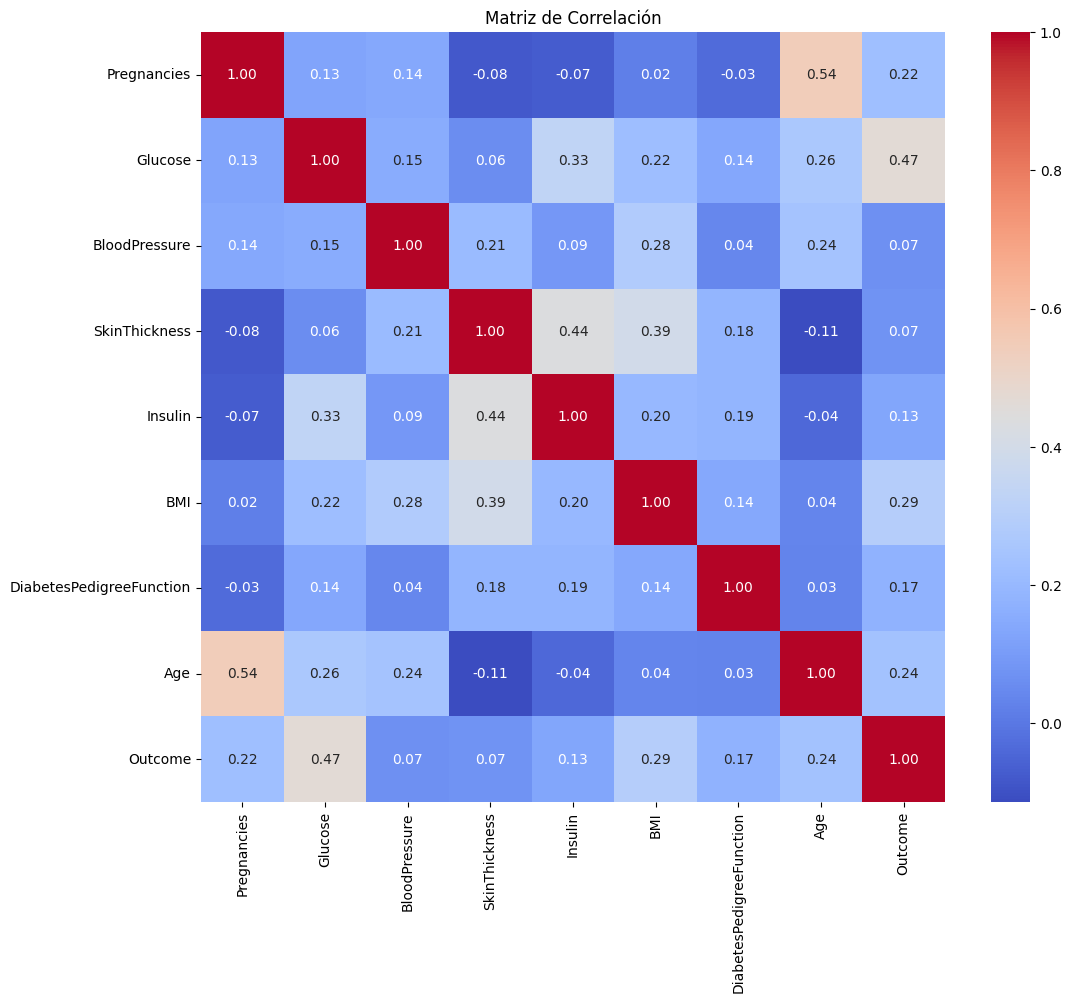

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_imputed.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Matriz de Correlación')
plt.show()

## Análisis de la Matriz de Correlación

### Correlación con Outcome: 
Glucosa y BMI parecen tener correlaciones más significativas con la variable objetivo (Outcome), lo que indica que son importantes predictores para la presencia de diabetes.

### Correlaciones entre Predictores: 
Insulina y SkinThickness, así como Age y Pregnancies, muestran correlaciones moderadas entre sí. Esto podría ser de interés ya que podrían estar proporcionando información parcialmente redundante.

No hay evidencia de correlaciones extremadamente altas entre las variables independientes que puedan sugerir un problema inmediato de multicolinealidad.

In [17]:
X = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Escalado Min-Max en el conjunto de entrenamiento (consideramos suficiente para normalizar los datos y tratar los outliers)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar el mismo escalado al conjunto de prueba
X_test_scaled = scaler.transform(X_test)

# Transformación logarítmica para las variables con sesgo significativo en el conjunto de entrenamiento
skewed_features = ['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction']
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled[skewed_features] = X_train_scaled[skewed_features].apply(lambda x: np.log1p(x))

# Aplicar la misma transformación al conjunto de prueba
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled[skewed_features] = X_test_scaled[skewed_features].apply(lambda x: np.log1p(x))

In [20]:
# Vamos a estudiar el árbol de decisión usando los criterios gini y entropy
criteria = ['gini', 'entropy']
for criterion in criteria:
    tree = DecisionTreeClassifier(criterion=criterion, random_state=42)
    tree.fit(X_train_scaled, y_train)
    y_pred = tree.predict(X_test_scaled)
    
    print(f"\nÁrbol de decisión usando {criterion}:")
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))


Árbol de decisión usando gini:
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79        99
         1.0       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


Árbol de decisión usando entropy:
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78        99
         1.0       0.61      0.65      0.63        55

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



In [22]:
# Definimos el espacio de parámetros para GridSearchCV
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5)
}

# Inicializamos el GridSearchCV con el modelo de árbol de decisión y los parámetros definidos
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")
best_tree = grid_search.best_estimator_

Mejores parámetros: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [23]:
# Evaluamos el mejor modelo encontrado con el conjunto de prueba
y_pred_best = best_tree.predict(X_test_scaled)
print("Reporte de clasificación para el mejor árbol:")
print(classification_report(y_test, y_pred_best))

Reporte de clasificación para el mejor árbol:
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76        99
         1.0       0.57      0.64      0.60        55

    accuracy                           0.70       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.71      0.70      0.70       154



## ANÁLISIS
Comparando estos resultados con el modelo base 'gini' que teníamos inicialmente:

La precisión para la clase negativa (0.0) ha disminuido ligeramente del 83% al 78%, y para la clase positiva (1.0) ha disminuido del 62% al 57%.

El recall para la clase negativa ha disminuido de 76% a 74%, pero para la clase positiva ha disminuido ligeramente de 73% a 64%.

La exactitud (accuracy) general ha bajado del 75% al 70%.

#### La reducción en la exactitud y otras métricas podría ser una señal de que el modelo está menos sobreajustado a los datos de entrenamiento y potencialmente podría generalizar mejor en datos no vistos. Sin embargo, esta hipótesis debe ser validada con una evaluación más extensa, posiblemente a través de la validación cruzada.

In [25]:
# Realizamos validación cruzada en el conjunto completo de datos
# Usamos el mejor árbol encontrado por GridSearchCV
cross_val_scores = cross_val_score(best_tree, X, y, cv=5, scoring='accuracy')

# Mostramos los resultados
cross_val_scores_mean = cross_val_scores.mean()
cross_val_scores_std = cross_val_scores.std()

cross_val_scores_mean, cross_val_scores_std

(0.7279178338001867, 0.02902179333216417)

## ANÁLISIS
Los resultados de la validación cruzada indican una media de exactitud de aproximadamente 72.79% con una desviación estándar de 2.90%. La media de la exactitud es una buena indicación de cómo el modelo podría desempeñarse en promedio cuando se aplica a nuevos datos. La desviación estándar es relativamente baja, lo que sugiere que el rendimiento del modelo es bastante estable a través de diferentes subdivisiones del conjunto de datos.

Una exactitud promedio de alrededor del 72.79% es comparable a los resultados de exactitud que obtuvimos en el conjunto de prueba después de la optimización de hiperparámetros, lo cual es positivo porque sugiere que no hay una variabilidad significativa en el rendimiento del modelo debido al sobreajuste.

In [27]:
dump(best_tree, open("decision_tree_classifier_best_42.sav", "wb"))